### Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [1]:
import pandahouse as ph
import pandas as pd

In [2]:
# было недостаточно прав
connection = dict(database='default',
                  host='https://clickhouse.lab.karpov.courses',
                  user='***',
                  password='***')

In [3]:
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'***', 
                      'password':'***'
                     }

In [23]:
query = """
SELECT COUNT(id)
FROM default.ldn_listings
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,count(id)
0,85207


## Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:

In [ ]:
# +-----------------+------------+
# | room_type       | price      |
# +-----------------+------------+
# | Private room    |         65 | 
# | Entire home/apt |        100 | 
# +-----------------+------------+

In [24]:
query = """
SELECT
    id,
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM default.ldn_listings
ORDER BY
    id
LIMIT 1000
"""
df2 = ph.read_clickhouse(query, connection=connection_default)
df2

,id,room_type,price
0,13913,Private room,65.0
1,15400,Entire home/apt,100.0
2,17402,Entire home/apt,300.0
3,17506,Private room,150.0
4,25023,Entire home/apt,65.0
...,...,...,...
995,541081,Entire home/apt,110.0
996,541363,Entire home/apt,110.0
997,542231,Private room,65.0
998,542646,Entire home/apt,100.0


In [25]:
df2.groupby('room_type', as_index=False).price.quantile(0.75)

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


## К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

In [26]:
query = """
SELECT
    id,
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM default.ldn_listings
WHERE  review_scores_rating is not null
ORDER BY
    id
LIMIT 1000
"""
df3 = ph.read_clickhouse(query, connection=connection_default)
df3_1 = df3.groupby('room_type', as_index=False).agg({'price': 'mean', 'review_scores_rating': 'mean'})

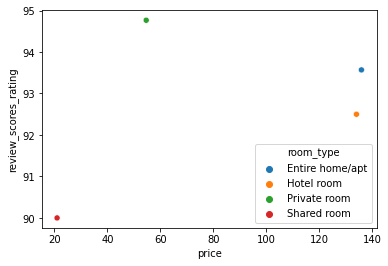

In [27]:
import seaborn as sns
sns.scatterplot(data=df3_1, x='price', y='review_scores_rating', hue='room_type')

### Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

In [28]:
query = '''
SELECT DISTINCT host_id, host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
'''
df4 = ph.read_clickhouse(query, connection=connection_default)

In [29]:
df4.dtypes

host_id               uint32
host_verifications    object
dtype: object

In [30]:
df4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [31]:
def string(string):
    string = string.strip('[').strip(']').replace('"', '')
    string = string.split(', ')
    return string

In [32]:
# df4['host_verifications'] = string(df4['host_verifications'])
# df4['host_verifications'] = df4[['host_verifications']].apply(lambda x: string(x['host_verifications'], axis=1))

df4['host_verifications'] = df4.apply(lambda x: string(x['host_verifications']), axis=1)

In [33]:
df4

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [34]:
df4.explode('host_verifications').groupby('host_verifications', as_index=False).agg({'host_id': 'count'})

,host_verifications,host_id
0,'email',1345
1,'facebook',270
2,'google',34
3,'government_id',1196
4,'identity_manual',227
5,'jumio',1115
6,'kba',27
7,'manual_offline',70
8,'manual_online',16
9,'offline_government_id',469


### Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

In [35]:
query = '''
SELECT neighbourhood_cleansed, experiences_offered 
FROM default.ldn_listings
WHERE experiences_offered != 'none'
'''
df5 = ph.read_clickhouse(query, connection=connection_default)

In [43]:
df5['experiences_count'] = 1

In [44]:
df5

,neighbourhood_cleansed,experiences_offered,experiences_count1,experiences_count
0,Islington,business,1,1
1,Kensington and Chelsea,romantic,1,1
2,Hammersmith and Fulham,business,1,1
3,Haringey,business,1,1
4,Barnet,business,1,1
...,...,...,...,...
1543,Croydon,family,1,1
1544,Islington,business,1,1
1545,Camden,business,1,1
1546,Islington,business,1,1


In [45]:
df5_1 = df5.groupby(['neighbourhood_cleansed', 'experiences_offered'], as_index=False) \
            .agg({'experiences_count': 'sum'}) \
            .sort_values('experiences_count', ascending=False).head(100)
df5_1

,neighbourhood_cleansed,experiences_offered,experiences_count
36,Hackney,family,61
98,Tower Hamlets,business,58
109,Westminster,business,50
38,Hackney,social,49
39,Hammersmith and Fulham,business,48
...,...,...,...
12,Bromley,family,2
30,Enfield,social,2
0,Barking and Dagenham,business,1
97,Sutton,romantic,1


In [46]:
df5_pivot = df5_1.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
df5_pivot

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,1.0,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,NaN,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0
Enfield,3.0,NaN,NaN,2.0


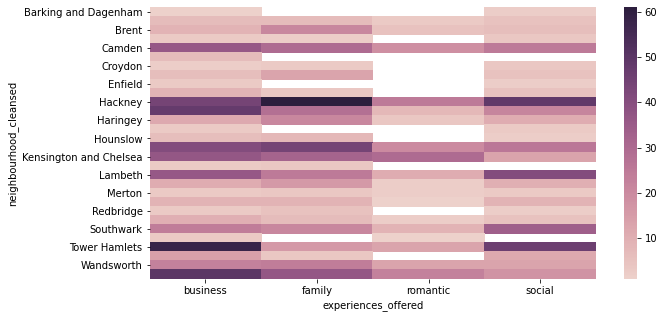

In [47]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df5_pivot, cmap=sns.cubehelix_palette(as_cmap=True))

### Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')

In [48]:
query = '''
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, experiences_offered
FROM default.ldn_listings
WHERE experiences_offered != 'none'
'''
df6 = ph.read_clickhouse(query, connection=connection_default)

In [49]:
df6

,room_type,price,experiences_offered
0,Private room,65.0,business
1,Entire home/apt,100.0,romantic
2,Private room,150.0,business
3,Private room,45.0,business
4,Private room,25.0,business
...,...,...,...
1543,Entire home/apt,100.0,family
1544,Entire home/apt,125.0,business
1545,Entire home/apt,185.0,business
1546,Entire home/apt,110.0,business


In [63]:
df6.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

**Далее постройте два графика, используя distplot из библиотеки seaborn:**

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

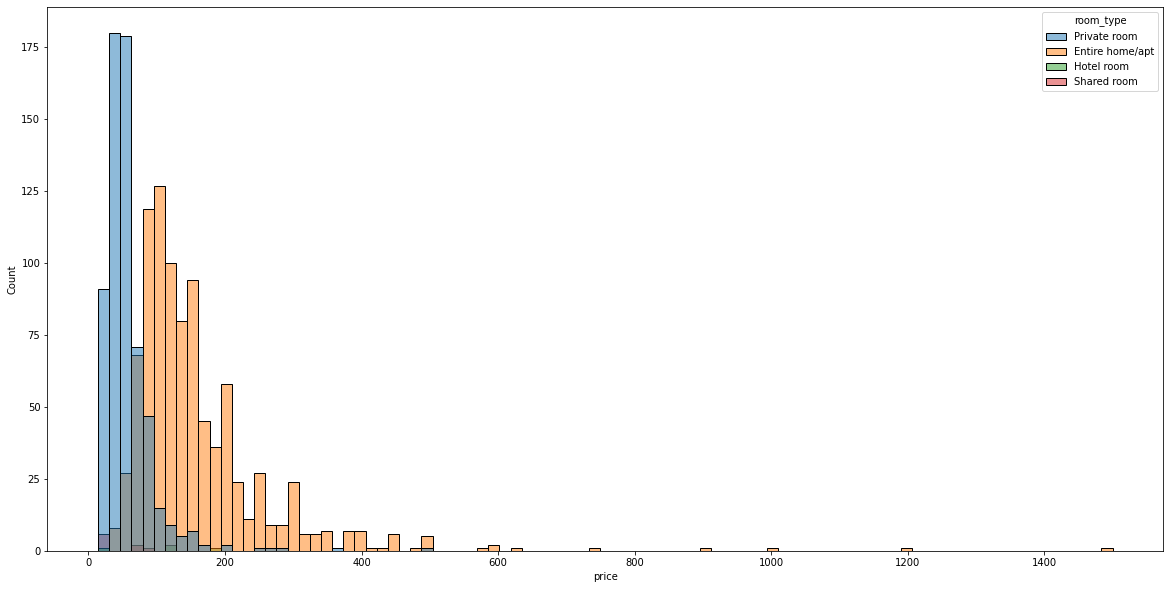

In [59]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df6, x='price', hue='room_type')

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


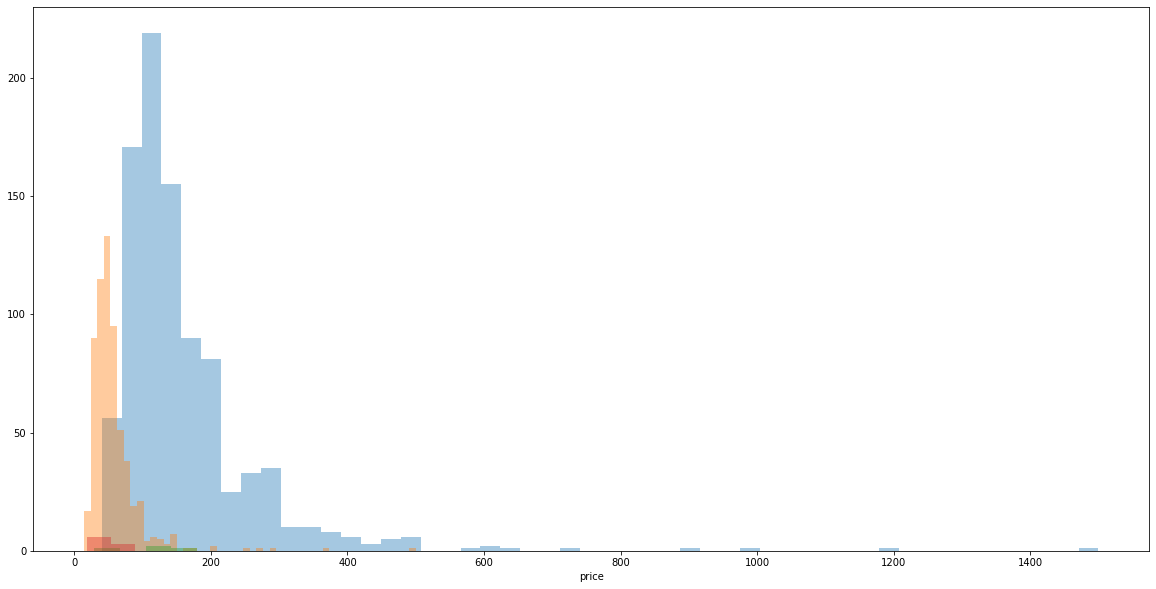

In [65]:
plt.figure(figsize=(20, 10))
sns.distplot(df6.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df6.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df6.query("room_type=='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df6.query("room_type=='Shared room'").price, kde=False, label='Shared room')

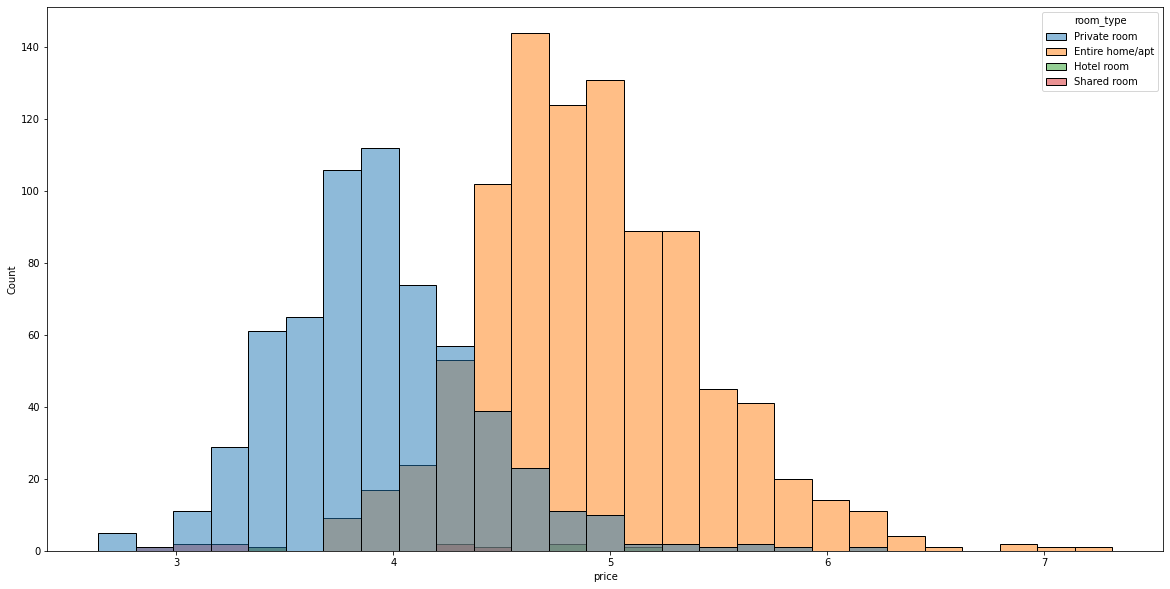

In [62]:
import numpy as np
plt.figure(figsize=(20, 10))
sns.histplot(x=np.log(df6.price), hue=df6.room_type)

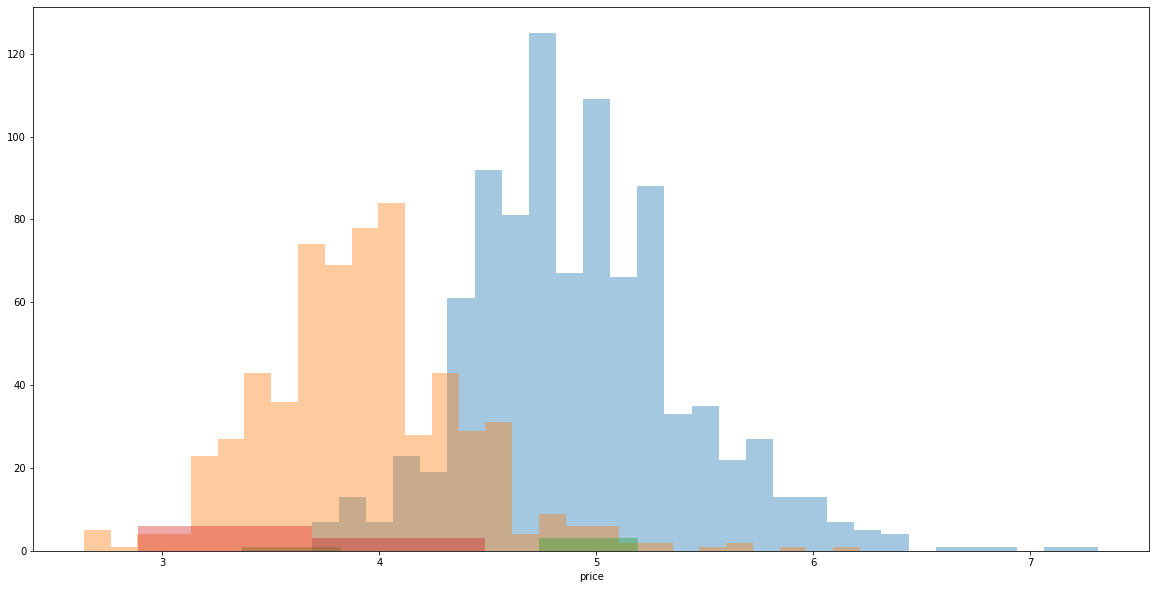

In [67]:
plt.figure(figsize=(20, 10))
sns.distplot(np.log(df6.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df6.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df6.query("room_type=='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df6.query("room_type=='Shared room'").price), kde=False, label='Shared room')

**Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:**

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

In [86]:
query = '''
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    first_review
FROM
    default.ldn_listings
WHERE
    toDateOrNull(first_review) > '2010-01-01'
LIMIT 1000
'''
df7=ph.read_clickhouse(query, connection=connection_default)

In [83]:
df7.head()

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16


Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

In [88]:
df7['first_review'] = df7['first_review'].apply(lambda x: x.split('-')[0])

In [89]:
df7

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [94]:
df7_1 = df7.groupby(['room_type', 'first_review'], as_index=False) \
.agg({'price': 'mean'})
df7_1

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


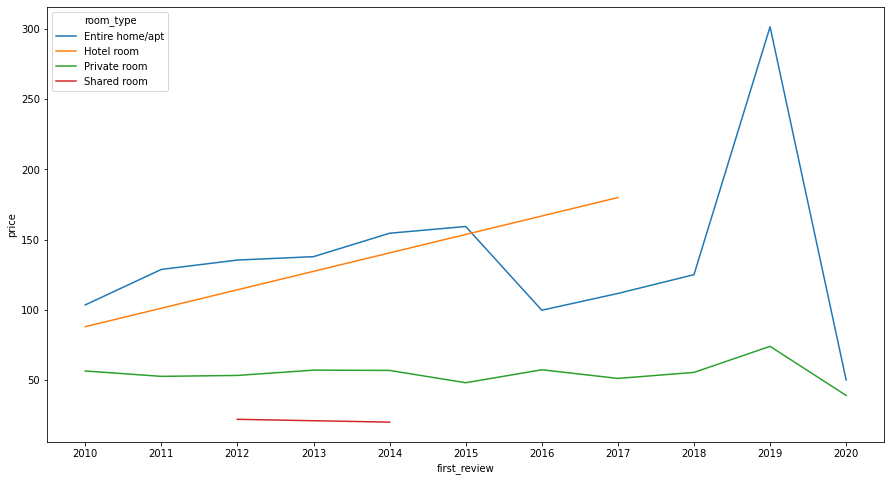

In [95]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=df7_1, x='first_review', y='price', hue='room_type')

In [5]:
query = """
SELECT
    CustomerID,
    toStartOfMonth(InvoiceDate) AS Date,
    SUM(Quantity * CAST(UnitPrice AS Float64)) AS revenue
FROM
    default.retail
WHERE
    Quantity > 0
GROUP BY
    toStartOfMonth(InvoiceDate),
    CustomerID
"""
retail = ph.read_clickhouse(query, connection=connection_default)
retail

,CustomerID,Date,revenue
0,14138,2011-12-01,344.17
1,14216,2011-12-01,586.56
2,12471,2011-01-01,753.45
3,14060,2011-12-01,297.48
4,13926,2011-11-01,223.85
...,...,...,...
13050,16212,2011-03-01,498.15
13051,17306,2011-09-01,1082.92
13052,16722,2011-09-01,422.08
13053,16438,2011-09-01,204.40


In [6]:
import seaborn as sns

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


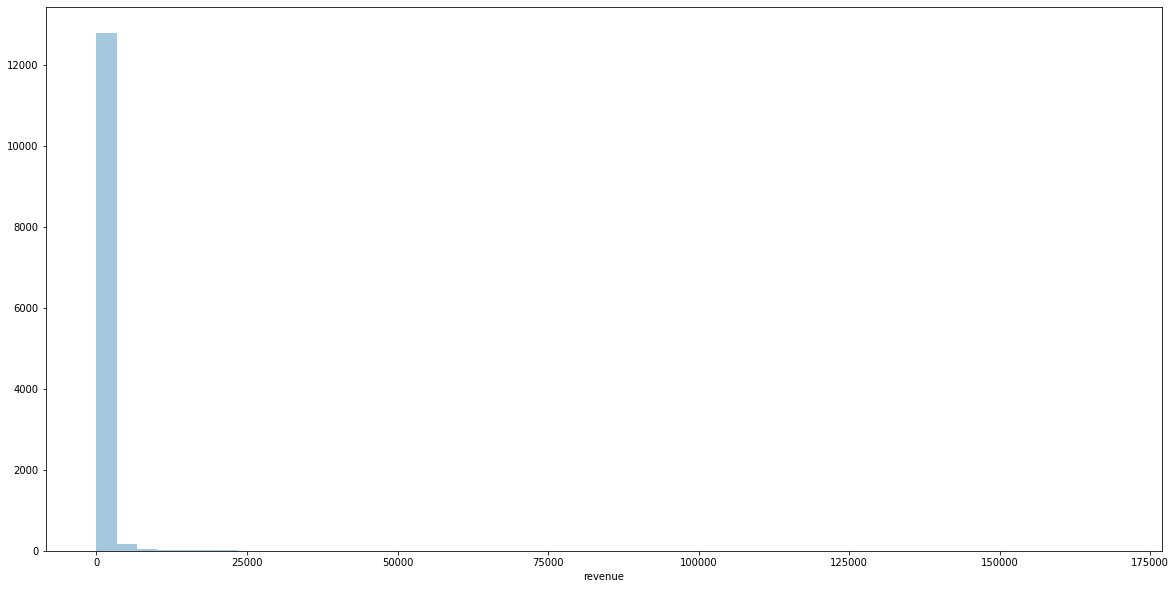

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.distplot(retail.revenue, kde=False)

In [4]:
query = '''
SELECT
        toStartOfQuarter(InvoiceDate) AS date,
        uniqExact(CustomerID) AS customers,
        Country
    FROM
        default.retail
    WHERE
        Quantity > 0
        AND
        Country IN ('United Kingdom', 'Netherlands', 'EIRE', 'Germany', 'France', 'Australia')
    GROUP BY
        toStartOfQuarter(InvoiceDate),
        Country
    HAVING
        toStartOfQuarter(InvoiceDate) != '2010-10-01'
'''
retail = ph.read_clickhouse(query, connection=connection_default)
retail

,date,customers,Country
0,2011-01-01,3,EIRE
1,2011-07-01,3,EIRE
2,2011-07-01,1939,United Kingdom
3,2011-10-01,3,Australia
4,2011-04-01,43,France
5,2011-10-01,2,EIRE
6,2011-10-01,59,Germany
7,2011-04-01,3,EIRE
8,2011-10-01,6,Netherlands
9,2011-01-01,38,France
